In [1]:
library(lme4)
options(rgl.useNULL=TRUE)
library(LMERConvenienceFunctions)

library(ggplot2)
options(jupyter.plot_mimetypes = 'image/png')
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

library(car)
library(MASS)

library(vcd)

Loading required package: Matrix
Loading required package: grid


# Score

In this notebook, we document our various steps taken to study the effect of the course of a session on the score a comment receives. Note that we only do this on a sample of 1 mio. data points here.

In [2]:
data = read.csv("/home/psinger/Reddit-depletion/data/sample.csv", header=TRUE)

In [3]:
nrow(data)

[1] 1000000

## Data inspection

We start by getting a better feeling of our data. 

We can limit our data to those sessions that have at least two comments.

In [4]:
idx = data$session_comments>1

In [5]:
data = data[idx,]

In [6]:
nrow(data)

[1] 669019

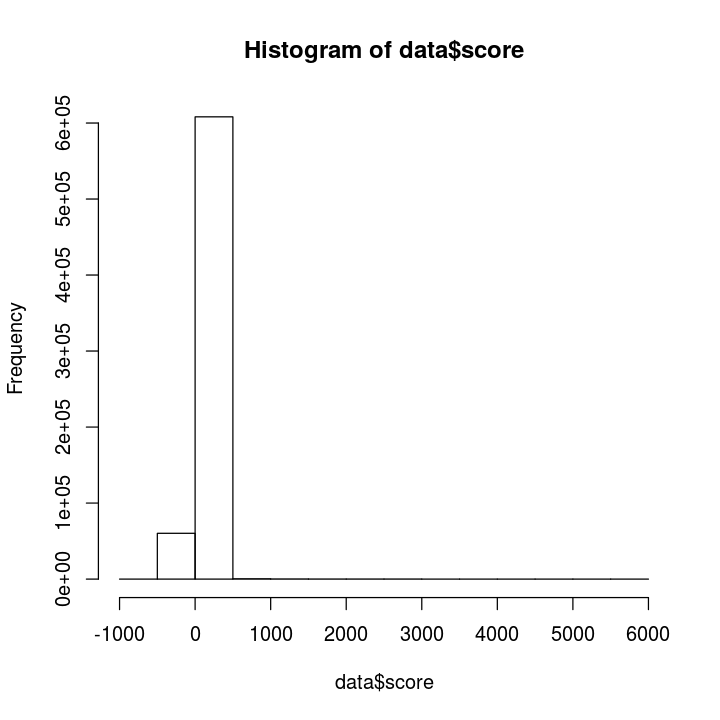

In [7]:
hist(data$score)

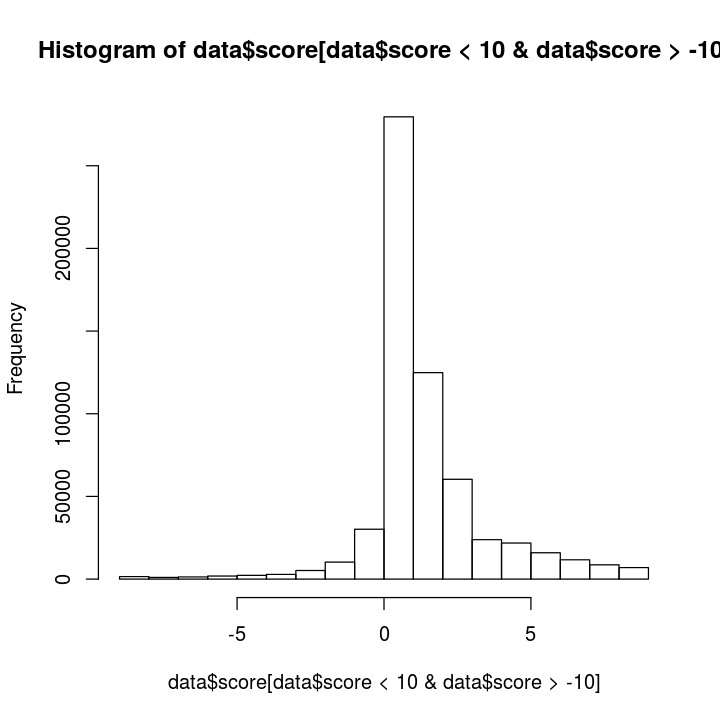

In [8]:
hist(data$score[data$score<10&data$score>-10])

## Regression model

We use mixed-effects models where in the basic form (that we analyze in this notebook), we are interested in studying score ~ 1 + session_index + session_comments + (1|author).

### Linear mixed-effects regression

We start with a linear mixed-effects model.

In [9]:
m_lmer = lmer(score~1+session_index + session_comments+(1|author), data=data, REML=FALSE)

In [10]:
summary(m_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: score ~ 1 + session_index + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 7256860  7256917 -3628425  7256850   669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-12.549  -0.088  -0.072  -0.048 107.995 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept)   60.4    7.771  
 Residual             2950.3   54.317  
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                  Estimate Std. Error t value
(Intercept)       5.969414   0.076090   78.45
session_index    -0.034962   0.009024   -3.87
session_comments  0.010872   0.005641    1.93

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.045       
sssn_cmmnts -0.190 -0.821

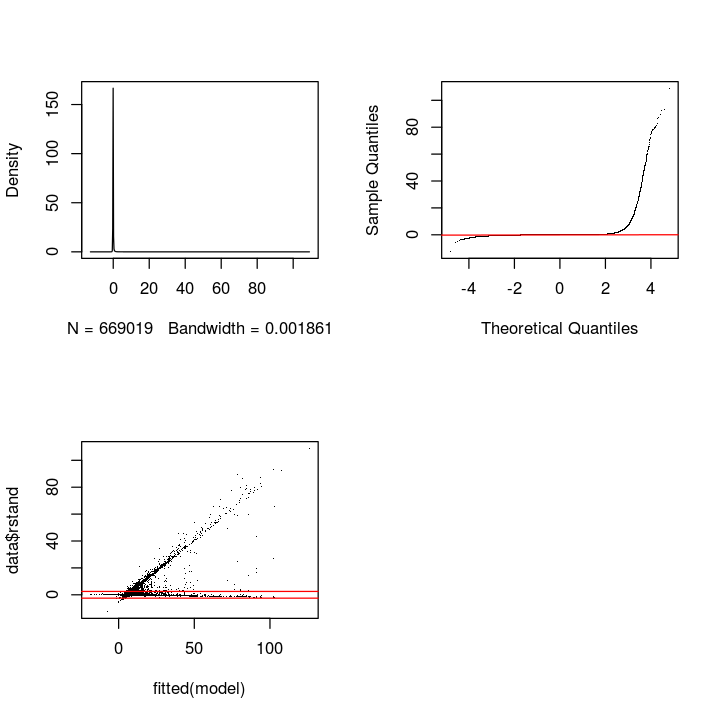

In [11]:
mcp.fnc(m_lmer)

What we can see in above plot is, that the residuals do not appear to be normally distributed and we can see clear heteroskedasticity. Thus, a linear model does not provide a good fit here.

### Linear mixed-effects regression (log-transform)

Next, let us take the log of the response variable and repeat a linear regression. However, we first add a constant to the data in order to make all outcomes positive.

In [40]:
min(data$score)
data$score.t = data$score + abs(min(data$score))

[1] -689

In [41]:
m_lmer_log = lmer(log1p(score.t)~1+session_index+session_comments+(1|author), data=data, REML=FALSE)

In [42]:
summary(m_lmer_log)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log1p(score.t) ~ 1 + session_index + session_comments + (1 |  
    author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
-2367429 -2367372  1183720 -2367439   669014 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-156.166   -0.139   -0.107   -0.061   53.816 

Random effects:
 Groups   Name        Variance  Std.Dev.
 author   (Intercept) 6.112e-05 0.007818
 Residual             1.644e-03 0.040545
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       6.544e+00  5.837e-05  112110
session_index    -3.925e-05  6.761e-06      -6
session_comments  1.097e-05  4.294e-06       3

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.046       
sssn_cmmnts -0.194 -0.806

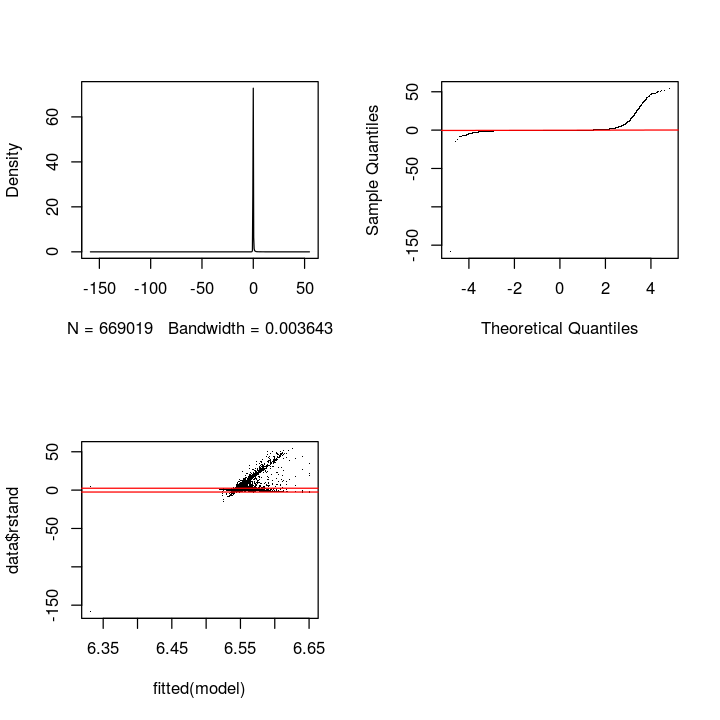

In [43]:
mcp.fnc(m_lmer_log)

That does not look satisfying at all. We should focus on generalized mixed-effects models to better model the count data.

### Poisson GLMER

Let us start with a Poisson GLMER, which is a main choice when working with count data.

In [72]:
m_poisson = glmer(score.t~1+session_index+session_comments+(1|author),data=data,family=poisson())

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.100966 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [73]:
summary(m_poisson)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_index + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6912223  6912269 -3456108  6912215   669015 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.825  -0.090  -0.059  -0.009 149.888 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001212 0.03481 
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       6.543e+00  8.675e-05   75425  < 2e-16 ***
session_index    -4.332e-05  6.493e-06      -7 2.53e-11 ***
session_comments  1.202e-05  4.507e-06       3  0.00763 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.036       
sssn_cmmnts -0.134 -0.724
convergence code: 0
Model fa

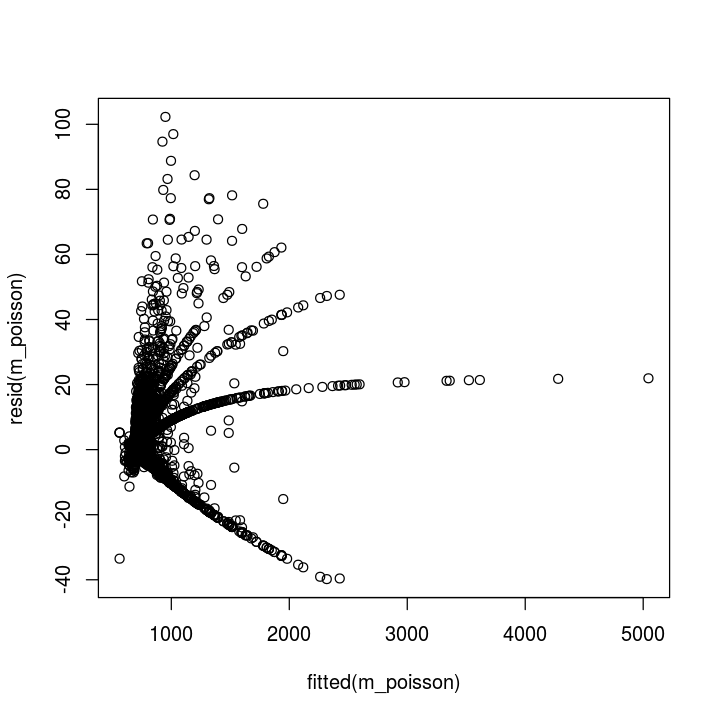

In [74]:
plot(fitted(m_poisson),resid(m_poisson))

The convergence message shows low magnitude and for such large data this might be a false positive as emphasized in the lme4 docu. 

The residual plots for generalized linear models are generally quite difficult to interpret as the residuals do not necessarily need to follow a normal distribution any longer. However, the fitted vs. residual plots shows a typical pattern for Poisson regression with curvilinear traces. What we can do though as a first step here, is to look at overdispersion (see http://glmm.wikidot.com/faq).

In [47]:
overdisp_fun <- function(model) {
  ## number of variance parameters in 
  ##   an n-by-n variance-covariance matrix
  vpars <- function(m) {
    nrow(m)*(nrow(m)+1)/2
  }
  model.df <- sum(sapply(VarCorr(model),vpars))+length(fixef(model))
  rdf <- nrow(model.frame(model))-model.df
  rp <- residuals(model,type="pearson")
  Pearson.chisq <- sum(rp^2)
  prat <- Pearson.chisq/rdf
  pval <- pchisq(Pearson.chisq, df=rdf, lower.tail=FALSE)
  c(chisq=Pearson.chisq,ratio=prat,rdf=rdf,p=pval)
}

In [48]:
overdisp_fun(m_poisson)

ERROR: Error in VarCorr(model): object 'm_poisson' not found


It does not seem that we have any problem with overdispersion here.

Let us be sure and check it with the dispersion_glmer function from the blmeco packages. 

In [49]:
library("blmeco") 
dispersion_glmer(m_poisson)

ERROR: Error in resid(modelglmer): object 'm_poisson' not found


The value is between 0.75 and 1.4 which gives an indicator that there is no overdispersion problem.

Again, for completeness, we fit a negative binomial regression with quasi likelihood.

In [50]:
#just for initialization
init = glm.nb(score.t~1+session_index+session_comments,data=data)

In [51]:
init$theta

[1] 575.5958

In [52]:
m_pql_nb = glmmPQL(score.t~1+session_index, random = list(~1 | author), data = data, family = negative.binomial(theta=init$theta))

iteration 1


In [53]:
summary(m_pql_nb)

Linear mixed-effects model fit by maximum likelihood
 Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | author
        (Intercept) Residual
StdDev:   0.0111774 1.386951

Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects: score.t ~ 1 + session_index 
                  Value    Std.Error     DF  t-value p-value
(Intercept)    6.543908 1.075192e-04 364914 60862.70   0e+00
session_index -0.000030 7.423850e-06 364914    -4.01   1e-04
 Correlation: 
              (Intr)
session_index -0.359

Standardized Within-Group Residuals:
         Min           Q1          Med           Q3          Max 
-12.54629770  -0.08866160  -0.07175236  -0.04799924 107.98404776 

Number of Observations: 669019
Number of Groups: 304104 

Again, very similar results.

## Final model choice

Given our extensive analysis regarding the appropriate model for our data, we can conclude that all have very similar conclusions, namely that the session_index has a negative effect on score. For the rest of this section, let us focus on Poisson regression that seems to be appropriate for this count data at hand.

## Significance of effects

Now that we have decided on a model, we want to extend our inference. First, we want to study the significance of the fixed effects as well as potential additional random effects. 

There are several options for determining the significance of a fixed effect on the model. For example, a common approach is to use the ratio of the slope to its standard error and then use a t-test for determining its significance. Alternatively, one can also use F-tests for contrasting simpler to more complex models. Both methods require a specification of the degrees of freedom though which is not trivial in mixed models; methods such as the Satterthwaite approximation or Kenward-Roger approximation can be used for that task. 
As stated in Baayen 2008, we can also directly use the t-statistics given to derive statistical significance. Because we have a huge dataset, a t-statistic above 2 can be regarded as significant at the 5\% level in a two-tailed test. You can derive this directly from the results above.

However, here, we follow an approach used for comparing models: the Bayesian Information Criterion (alternatively we could also work with AIC or LRT). Basically, the idea is to specify different (in this case nested) models that successively incorporate additional fixed or random effects and then compare their BIC scores. The lower the BIC, the better a model is (above a small threshold).

The baseline model we start with is:

score = 1 + (1|author)

The reason why we incorporate the random effect for author from the beginning is that this is necessary based on the design of the experiment. Also, as pointed out in http://glmm.wikidot.com/faq, you should not compare the fit of a (g)lmer with one from a (g)lm.

Okay, so let us get the BIC for the baseline model.

In [54]:
m1 = glmer(score.t~1+(1|author), data = data, family=poisson())
summary(m1)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00129788 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6912273  6912296 -3456135  6912269   669017 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.825  -0.089  -0.060  -0.009 149.903 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001212 0.03481 
Number of obs: 669019, groups:  author, 304104

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) 6.543e+00  8.431e-05   77606   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
convergence code: 0
Model failed to converge with max|grad| = 0.00129788 (tol = 0.001, component 1)
Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?


Next, let us incorporate the index and session length individually.

In [55]:
m2 = glmer(score.t~1+session_index+(1|author), data = data, family=poisson())
summary(m2)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.125634 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_index + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6912228  6912262 -3456111  6912222   669016 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.824  -0.090  -0.059  -0.008 149.885 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001212 0.03481 
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    6.543e+00  8.596e-05   76117  < 2e-16 ***
session_index -3.076e-05  4.475e-06      -7 6.25e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
session_ndx -0.195
convergence code: 0
Model failed to converge with max|grad| = 0.125634 (tol = 0.001, component 1)
Model is nearly unidentifiable: very large eigenvalue
 - R

In [56]:
m3 = glmer(score.t~1+session_comments+(1|author), data = data, family=poisson())
summary(m3)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0334648 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6912266  6912300 -3456130  6912260   669016 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.824  -0.090  -0.059  -0.009 149.894 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001212 0.03481 
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       6.543e+00  8.669e-05   75472  < 2e-16 ***
session_comments -9.782e-06  3.107e-06      -3  0.00164 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.233
convergence code: 0
Model failed to converge with max|grad| = 0.0334648 (tol = 0.001, component 1)
Model is nearly unidentifiable: very large ei

Based on the lower BIC we can clearly see that the incorporation of the session_index and session_comments (separately) improve our model, thus, we make inference on it (also the t-value indicates high significance).

In [57]:
m4 = glmer(score.t~1+session_index+session_comments+(1|author), data = data, family=poisson())
summary(m4)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.100966 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_index + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6912223  6912269 -3456108  6912215   669015 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.825  -0.090  -0.059  -0.009 149.888 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001212 0.03481 
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       6.543e+00  8.675e-05   75425  < 2e-16 ***
session_index    -4.332e-05  6.493e-06      -7 2.53e-11 ***
session_comments  1.202e-05  4.507e-06       3  0.00763 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.036       
sssn_cmmnts -0.134 -0.724
convergence code: 0
Model fa

As expected based on our initial empirical analysis in the paper, both the session index and session length are important effect to incorporate.

We stop at this point as our scope of interest is covered. However, one can arbitrarily extend the existing model.
For example, one might also argue that it is necessary to incorporate a random effect for the intercept based on different subreddits.

In [58]:
m5 = glmer(score.t~1+session_index+session_comments+(1|author)+(1|subreddit), data = data, family=poisson())
summary(m5)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0915295 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_index + session_comments + (1 | author) +  
    (1 | subreddit)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6907341  6907398 -3453666  6907331   669014 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.779  -0.114  -0.039   0.015 149.709 

Random effects:
 Groups    Name        Variance  Std.Dev.
 author    (Intercept) 1.196e-03 0.034578
 subreddit (Intercept) 1.015e-05 0.003186
Number of obs: 669019, groups:  author, 304104; subreddit, 12583

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       6.540e+00  1.256e-04   52073  < 2e-16 ***
session_index    -4.453e-05  6.496e-06      -7 7.14e-12 ***
session_comments  7.623e-06  4.523e-06       2   0.0919 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (I

Again, the BIC shows an improvement in the model. Yet, the inference on the fixed effects does not change. For complexity reasons, we neglect the random effect for the subreddit for the complete data.

### Collinearity

We also want to check for multicollinearity in our model; some explanations and code for checking that in lme4 is provided in https://hlplab.wordpress.com/2011/02/24/diagnosing-collinearity-in-lme4/.

In [59]:
source("mer-utils.R")
kappa.mer(m4)
max(vif.mer(m4))

[1] 4.566001

[1] 2.104578

Both the condition number and VIF show no reasons to be concerned about collinearity in this model.

### Length as random effect

We have decided to incorporate the variation between different session lengths as a controlling covariate, however we might also incorporate it as a controlling random effect.

In [68]:
m4_control = glmer(score.t~1+session_index+(1|session_comments)+(1|author), data = data, family=poisson())
summary(m4_control)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 1.77556 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_index + (1 | session_comments) + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6911986  6912032 -3455989  6911978   669015 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.817  -0.096  -0.061  -0.008 149.788 

Random effects:
 Groups           Name        Variance  Std.Dev.
 author           (Intercept) 1.212e-03 0.034815
 session_comments (Intercept) 6.111e-05 0.007818
Number of obs: 669019, groups:  author, 304104; session_comments, 328

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    6.544e+00  7.130e-04    9177  < 2e-16 ***
session_index -3.339e-05  5.581e-06      -6  2.2e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
session_ndx -0.437
convergence code: 0
Model failed to c

The results are similar.

## Randomized baseline data

In order to finally confirm our intuition and inference on the negative effect of the session index on the number of responses, we also study our randomized baseline data. We basically have two different randomized datasets: (i) new sessions based on randomized time differences and (ii) randomized positions inside existing sessions.

In [61]:
idx = data$session_comments_random > 1
data_random = data[idx,]

In [62]:
m1_random = glmer(score.t~1+(1|author), data = data_random, family=poisson())
summary(m1_random)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00297257 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 5502763  5502785 -2751380  5502759   533136 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-34.137  -0.087  -0.057  -0.006 149.817 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001284 0.03583 
Number of obs: 533138, groups:  author, 232025

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) 6.543e+00  9.787e-05   66851   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
convergence code: 0
Model failed to converge with max|grad| = 0.00297257 (tol = 0.001, component 1)
Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?


In [63]:
m2_random = glmer(score.t~1+session_index_random+(1|author), data = data_random, family=poisson())
summary(m2_random)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.131815 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_index_random + (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 5502765  5502798 -2751379  5502759   533135 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-34.137  -0.087  -0.057  -0.007 149.817 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001284 0.03583 
Number of obs: 533138, groups:  author, 232025

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           6.543e+00  1.002e-04   65285   <2e-16 ***
session_index_random -3.197e-06  7.030e-06       0    0.649    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_ndx_rn -0.215
convergence code: 0
Model failed to converge with max|grad| = 0.131815 (tol = 0.001, component 1)
Model is nearly unident

In [64]:
m3_random = glmer(score.t~1+session_comments_random+(1|author), data = data_random, family=poisson())
summary(m3_random)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.18004 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_comments_random + (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 5502763  5502797 -2751379  5502757   533135 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-34.136  -0.087  -0.056  -0.007 149.814 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001284 0.03583 
Number of obs: 533138, groups:  author, 232025

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              6.543e+00  1.013e-04   64586   <2e-16 ***
session_comments_random -6.541e-06  5.084e-06      -1    0.198    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnt_ -0.258
convergence code: 0
Model failed to converge with max|grad| = 0.18004 (tol = 0.001, component 1)
Model is nea

In [65]:
m4_random = glmer(score.t~1+session_index_random+session_comments_random+(1|author), data = data_random, family=poisson())
summary(m4_random)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.235051 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_index_random + session_comments_random +  
    (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 5502765  5502810 -2751378  5502757   533134 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-34.136  -0.087  -0.056  -0.007 149.813 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001284 0.03583 
Number of obs: 533138, groups:  author, 232025

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              6.543e+00  1.014e-04   64547   <2e-16 ***
session_index_random     7.409e-06  1.033e-05       1    0.473    
session_comments_random -1.047e-05  7.472e-06      -1    0.161    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n_
sssn_ndx_rn -0.035      

When comparing m3_random and m4_random, we can see now is that the incorporation of the session index is not improving the model in terms of the BIC score  and is thus, not significant (also has a low t-value < 2). 

The reason why the session length itself is still significant can be explained by our very conservative randomization method that just randomizes the time differences between comments before sessionizing and thus, still keeps many sessions intact.

### Randomized indexes

In [69]:
m3_random_2 = glmer(score.t~1+session_comments+(1|author), data = data, family=poisson())
summary(m3_random_2)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0334648 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6912266  6912300 -3456130  6912260   669016 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.824  -0.090  -0.059  -0.009 149.894 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001212 0.03481 
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       6.543e+00  8.669e-05   75472  < 2e-16 ***
session_comments -9.782e-06  3.107e-06      -3  0.00164 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.233
convergence code: 0
Model failed to converge with max|grad| = 0.0334648 (tol = 0.001, component 1)
Model is nearly unidentifiable: very large ei

In [71]:
m4_random_2 = glmer(score.t~1+session_index_random_2+session_comments+(1|author), data = data, family=poisson())
summary(m4_random_2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: score.t ~ 1 + session_index_random_2 + session_comments + (1 |  
    author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 6912266  6912311 -3456129  6912258   669015 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-33.824  -0.090  -0.059  -0.009 149.894 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.001212 0.03481 
Number of obs: 669019, groups:  author, 304104

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             6.543e+00  8.674e-05   75429  < 2e-16 ***
session_index_random_2  9.208e-06  6.439e-06       1  0.15271    
session_comments       -1.445e-05  4.505e-06      -3  0.00134 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) ss___2
sssn_ndx__2 -0.034       
sssn_cmmnts -0.

Again, we see similar behavior, the incorporation of the random session index does not improve the model compared to one that already includes the session length.

Overall, the analyses presented in this notebook have demonstrated that the course of a session has a (negative) effect on the score a post receives.